# Open Library EDA

Using some [Open Library data dumps](https://openlibrary.org/developers/dumps) we'll go through and understand the metadata that's in the files.

## Editions

* 70% of the editions have been automatically imported from one of MARC, Better World Books, Internet Archive, or Amazon (listed in `source_records`)
* 64% of editions have at least one ISBN 10 or ISBN 13
* Almost always have a `title`, and sometimes a `subtitle` a `full_title` (which is often the concatenation of the `title` and `subtitle`), an `edition_name`, and occasionally `other_titles`
* Generally have `authors`, and sometimes a `by_statement` which is how the authors are listed as text in the book
* Editions often contain a `publisher`, `publish_date` and locations in `publish_places` and `publish_country` (the latter of which is often a US state)
* What the book is about is in `subjects`, `subject_places`, `subject_people`, `subject_time`, `lc_classifications`, `dewey_decimal_class`, and `genres`
* It can be connected to other databases using things like `lccn`, `oclc_numbers`, `identifiers`, `ocaid`, 
* Sometimes more information is in `notes`, a `table_of_contents`, `description`, or a `first_sentence`
* There are sometimes a `cover` image hosted on Open Library

## Works

* Works largely have a subset of the fields of editions, not always consistent with the editions
* The authors are normally a superset of the authors of the editions, typically there's only one author (89% of the time), and 5% of the time no author. 
* On average there's 1.3 editions per work

## Authors

* On average there's 1.1 works per author
* Most authors have a `name`, many a `personal_name`, and some `alternate_names` (and sometimes a `title`). They're often inconsistent with format (e.g. `Surname, Firstname` or `Firstname Surname`)
* Some have a `birth_date` and `death_date` which could be useful for disambiguation
* There are often `remote_ids` linking to wikidata, VIAF and ISNI where additional information can be obtained
* Sometimes there's a `bio`, `photos`

## Imports

In [1]:
from pathlib import Path

from collections import Counter

import xxhash

import gzip
import json

from tqdm.auto import tqdm

# Extracting a sample

We'll take a deterministic sample of the data we can keep in memory.

We'll sample on *work* and then collect all authors and editions for that work.

In [2]:
salt = b'openlibrary'

def intdigest(key: str) -> int:
    return xxhash.xxh32_intdigest(key.encode() + salt)

intdigest('/work/V1235M')

2016000756

We'll use the hash to select 1 in N works.

In [3]:
works_per_sample = 100

def in_sample(key: str) -> bool:
    return intdigest(key) % works_per_sample == 0

We can read in each of the data files.

In [4]:
ol_dump_date = '2022-06-06'
data_path = Path('../data/01_raw')

def ol_path(segment):
    return data_path / f'ol_dump_{segment}_{ol_dump_date}.txt.gz'

def ol_data(segment):
    with gzip.open(ol_path(segment), 'rt') as f:
        for line in f:
            yield tuple(line.split('\t', 5))

## Sampling works

And sample them.

In [5]:
work_metadata = {}

for record_type, key, revision, last_modified, json_metadata in tqdm(ol_data('works')):
    if in_sample(key):
        metadata = json.loads(json_metadata)
        work_metadata[key] = metadata

0it [00:00, ?it/s]

In [6]:
len(work_metadata)

252476

## Extracting the authors

Each work contains a list of `authors` with different roles (e.g. whether they wrote the text or the forward).

In [7]:
work = next(iter(work_metadata.values()))
work

{'title': 'Handbuch Handlungskompetenz. Einführung in die Selbst-, Sozial- und Methodenkompetenz',
 'created': {'type': '/type/datetime', 'value': '2009-12-11T01:59:46.639055'},
 'covers': [3165466],
 'last_modified': {'type': '/type/datetime',
  'value': '2010-04-28T06:54:19.472104'},
 'latest_revision': 3,
 'key': '/works/OL10015001W',
 'authors': [{'type': '/type/author_role',
   'author': {'key': '/authors/OL3981876A'}}],
 'type': {'key': '/type/work'},
 'revision': 3}

In [8]:
authors = [author['author']['key'] for author in work['authors']]
authors

['/authors/OL3981876A']

We can iterate over all the works to get a set of relevant authors.

In [9]:
authors = set()

for work in tqdm(work_metadata.values(), total=len(work_metadata)):
    if 'authors' in work:
        work_authors = [author['author']['key'] for author in work['authors'] if 'author' in author]
        authors.update(work_authors)

  0%|          | 0/252476 [00:00<?, ?it/s]

In [10]:
len(authors)

230850

In [11]:
author_metadata = {}

for record_type, key, revision, last_modified, json_metadata in tqdm(ol_data('authors')):
    if key in authors:
        metadata = json.loads(json_metadata)
        author_metadata[key] = metadata

0it [00:00, ?it/s]

Apparently a few authors are missing

In [12]:
len(authors) - len(author_metadata)

9

On average there's 1.1 works per author

In [13]:
len(work_metadata) / len(author_metadata)

1.093722518963269

## Editions

Finally let's take all editions referring to these works

In [14]:
record_type, key, revision, last_modified, json_metadata = next(ol_data('editions'))
metadata = json.loads(json_metadata)

We can extract the works

In [15]:
metadata['works']

[{'key': '/works/OL14903292W'}]

In [16]:
works = [w['key'] for w in metadata['works']]
works

['/works/OL14903292W']

And then check whether it's in our sample

In [17]:
any(w in work_metadata for w in works)

False

We can then get any edition with a work in the sample.

This is the slowest step because we're JSON decoding the metadata for every edition.
It would be faster to search for a key in the edition string using a regex, but to keep it simple we'll decode the JSON.

In [18]:
edition_metadata = {}

for record_type, key, revision, last_modified, json_metadata in tqdm(ol_data('editions')):
    metadata = json.loads(json_metadata)
    if 'works' in metadata and any(w['key'] in work_metadata for w in metadata['works']):
        edition_metadata[key] = metadata

0it [00:00, ?it/s]

In [19]:
len(edition_metadata)

329009

How many editions are there per work?

In [20]:
len(edition_metadata) / len(work_metadata)

1.3031298024366673

# Works Fields

What are the frequently used fields?

In [21]:
work_key_counts = Counter()

for m in tqdm(work_metadata.values()):
    work_key_counts.update(m.keys())

{k:v/len(work_metadata) for k,v in work_key_counts.most_common() if v/len(work_metadata) > 0.01}

  0%|          | 0/252476 [00:00<?, ?it/s]

{'title': 1.0,
 'created': 1.0,
 'last_modified': 1.0,
 'latest_revision': 1.0,
 'key': 1.0,
 'type': 1.0,
 'revision': 1.0,
 'authors': 0.9551640551973257,
 'subjects': 0.5822375196058239,
 'covers': 0.3138278489836658,
 'subject_places': 0.23616898239832698,
 'first_publish_date': 0.17625041588111345,
 'lc_classifications': 0.0943891696636512,
 'subject_people': 0.07341291845561558,
 'subject_times': 0.05751041683169886,
 'dewey_number': 0.04612319586812212,
 'description': 0.042697127647776424,
 'subtitle': 0.02249322707900949}

## Authors

Authors can have different roles

In [22]:
[m['authors'] for m in work_metadata.values() if 'authors' in m][:10]

[[{'type': '/type/author_role', 'author': {'key': '/authors/OL3981876A'}}],
 [{'type': {'key': '/type/author_role'},
   'author': {'key': '/authors/OL4094514A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4146725A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4153117A'}}],
 [{'type': {'key': '/type/author_role'},
   'author': {'key': '/authors/OL4153276A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4159451A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4162437A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4164231A'}}],
 [{'type': '/type/author_role', 'author': {'key': '/authors/OL4222275A'}}],
 [{'type': {'key': '/type/author_role'},
   'author': {'key': '/authors/OL4225571A'}}]]

In [23]:
author_type_counts = Counter()
for m in tqdm(work_metadata.values()):
    author_types = [a['type'] for a in m.get('authors', [])]
    author_types = [a['key'] if  isinstance(a, dict) else a for a in author_types]
    author_type_counts.update(author_types)

  0%|          | 0/252476 [00:00<?, ?it/s]

It seems like we only ever get the author role.

In [24]:
author_type_counts

Counter({'/type/author_role': 265058})

How many authors are there?

In [25]:
author_num_counts = Counter(len(m.get('authors', [])) for m in work_metadata.values())

{k:(f'{v/len(work_metadata):0.1%}', v) for k, v in sorted(author_num_counts.items())}

{0: ('4.5%', 11320),
 1: ('89.2%', 225209),
 2: ('4.3%', 10940),
 3: ('1.3%', 3352),
 4: ('0.4%', 968),
 5: ('0.2%', 509),
 6: ('0.0%', 60),
 7: ('0.0%', 28),
 8: ('0.0%', 23),
 9: ('0.0%', 17),
 10: ('0.0%', 20),
 11: ('0.0%', 9),
 12: ('0.0%', 7),
 13: ('0.0%', 3),
 14: ('0.0%', 2),
 15: ('0.0%', 3),
 17: ('0.0%', 3),
 18: ('0.0%', 1),
 19: ('0.0%', 1),
 20: ('0.0%', 1)}

## Subjects

Note the subjects are in many languages

In [26]:
[m['subjects'] for m in work_metadata.values() if 'subjects' in m][:10]

[['San xian', 'Method', 'Music', 'Instruction and study'],
 ['Post-traumatic stress disorder',
  'Psychic trauma',
  'Treatment',
  'Eclectic psychotherapy'],
 ['Indonesia. Departemen Dalam Negeri', 'Indonesia'],
 ['South African literature (English)'],
 ['Arsène Lupin (Fictitious character)', 'Fiction'],
 ['Histoire',
  'Berbères',
  'Philosophie',
  'Early works to 1800',
  'Philosophy',
  'History'],
 ['Banks and banking', 'Budget'],
 ['Procurement',
  'Defenses',
  'Strategic materials',
  'Law and legislation',
  'Armed Forces'],
 ['Appropriations and expenditures',
  'Harbors',
  'Management',
  'Prevention',
  'Security measures',
  'Shipping',
  'Terrorism',
  'United States',
  'United States. Coast Guard'],
 ['Real property', 'Study and teaching', 'Valuation']]

In [27]:
subject_counts = Counter()

for m in tqdm(work_metadata.values()):
    subject_counts.update(m.get('subjects', []))

  0%|          | 0/252476 [00:00<?, ?it/s]

In [28]:
subject_counts.most_common(20)

[('History', 16409),
 ('Biography', 6392),
 ('Fiction', 5522),
 ('Congresses', 4560),
 ('Politics and government', 4029),
 ('History and criticism', 3486),
 ('Juvenile literature', 2639),
 ('Law and legislation', 2424),
 ('Economic conditions', 1814),
 ('Catalogs', 1794),
 ('United States', 1733),
 ('Bibliography', 1699),
 ('Description and travel', 1627),
 ('Criticism and interpretation', 1614),
 ('Social conditions', 1545),
 ('Exhibitions', 1541),
 ('Education', 1515),
 ('Social life and customs', 1498),
 ('Juvenile fiction', 1449),
 ("Children's fiction", 1432)]

They get pretty broad further down the list

In [29]:
subject_counts.most_common(20000)[-1]

('Health Promotion', 3)

## Covers

In [30]:
[(m['title'], m['covers']) for m in work_metadata.values() if 'covers' in m][:10]

[('Handbuch Handlungskompetenz. Einführung in die Selbst-, Sozial- und Methodenkompetenz',
  [3165466]),
 ('San xian yan zou yi shu', [5235169]),
 ('Trauma, Culpa y Duelo', [3326754]),
 ('Las misiones del Paraguay/the Missions Of Paraguay', [5267844]),
 ('Joseph and His Brothers (Bible Stories)', [5061720]),
 ('The English Auden', [4413353]),
 ('A stranger and afraid', [4237710]),
 ("La fiction de l'Occident : Thomas Mann, Franz Kafka, Albert Cohen",
  [3707254]),
 ('Evenings with Idries Shah', [8543925]),
 ('Life of Tecumseh, and His Brother the Prophet', [6017579])]

Each cover identifier can be used to obtain the image from Open Library (e.g. below the size can be S, M, L for small, medium and large).

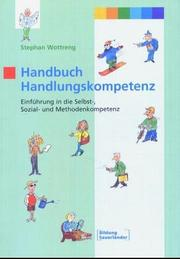

In [31]:
import requests
from IPython.display import Image

Image(requests.get('https://covers.openlibrary.org/b/id/3165466-M.jpg').content)

## Subject Places

Sometimes a book is about a place

In [32]:
[(m['title'], m['subject_places']) for m in work_metadata.values() if 'subject_places' in m][:10]

[('Peuples et nations du monde', ['Afrique du Nord']),
 ('Force and salaries, sub-treasury, New York. Letter from the Acting Secretary of the Treasury transmitting estimates of force and salaries of office of Assistant Treasurer at New York, in lieu of estimates heretofore submitted for the next fiscal year',
  ['United States', 'New York (N.Y.)']),
 ('H.R. 5074 and H.R. 5076', ['United States']),
 ('Maritime Transportation Amendments of 2004', ['United States']),
 ('An introduction to appraising real property', ['United States']),
 ("China's criminal justice system", ['China']),
 ('Employment promotion in the South Pacific region', ['Oceania']),
 ('A brief bibliography of Maryland folksong and dance', ['Maryland']),
 ('The evolution of industries in Peoria, Illinois',
  ['Peoria', 'Peoria (Ill.)', 'Illinois']),
 ("China's industrialization", ['China'])]

In [33]:
subject_places_counts = Counter()

for m in tqdm(work_metadata.values()):
    subject_places_counts.update(m.get('subject_places', []))
    
subject_places_counts.most_common(10)

  0%|          | 0/252476 [00:00<?, ?it/s]

[('United States', 8699),
 ('Great Britain', 2249),
 ('China', 2243),
 ('France', 2228),
 ('Germany', 1968),
 ('Italy', 1762),
 ('Japan', 1593),
 ('India', 1518),
 ('Canada', 1255),
 ('England', 1084)]

## First Publish Date

Sometimes we have a date of first publication

In [34]:
[(m['title'], m['first_publish_date']) for m in work_metadata.values() if 'first_publish_date' in m][:10]

[('Sources of weapon systems innovation in the Department of Defense', '2008'),
 ('Abstracts', '1996'),
 ('Councillors, committees, officers and calendar of meetings for 1994/95',
  '1994'),
 ('A stranger and afraid', '1983'),
 ('Lai zi hai yang de tiao zhan', '2004'),
 ('Diseases of cereal crops in Washington', '1964'),
 ('Household insects and their control', '1958'),
 ('Report from the Committee on the Woollen Manufacture of England', '1968'),
 ('Prameyaratnamala', '1964'),
 ('Nihon geinō yukue fumei', '1987')]

## Library of Congress Classifications

Library of Congress has a [classification system](https://www.loc.gov/catdir/cpso/lcc.html) with a [public outline](https://www.loc.gov/catdir/cpso/lcco/)

For example `U393 .L378 2008` means

* U3 - Military Science (General), weapons
* .L3 - Education (Reports)
* 2008 Publication Date 

Or `PR6011.R293 Z477 1983`

* PR6011 - English Literature 1900-1960
* .R293 - (subtopic) History of medicine. Medical expeditions
* Z477 - Book industries and trade - Bookselling and publishing
* 1983 - Publication year

In [35]:
[(m['title'], m['lc_classifications']) for m in work_metadata.values() if 'lc_classifications' in m][:10]

[('Sources of weapon systems innovation in the Department of Defense',
  ['U393 .L378 2008']),
 ('A stranger and afraid', ['PR6011.R293 Z477 1983']),
 ('Lai zi hai yang de tiao zhan', ['HF1604 .Z243 2004']),
 ('Prameyaratnamala', ['B132 N8 M4 1964']),
 ('Nihon geinō yukue fumei', ['PN2923 .N3 1987 <Orien Japan>']),
 ('La brousse, le champ et la jachère au Burkina Faso',
  ['HN828.A8 D86 2007']),
 ('Hombre a la par', ['PQ7798.17 U4 H6']),
 ('Die politische Entwicklung des ungarländischen Deutschtums während der Revolution 1918/19',
  ['DB926.5 G3 S26']),
 ('Effects of an increase in the tax base for unemployment compensation in Illinois',
  ['HD7096.U6 I32 1967']),
 ('ʻĀšūrāʾ-Feiern im Libanon', ['DS80.4 .R56 1993'])]

## Subject Times

A period to which the work applies

In [36]:
[(m['title'], m['subject_times']) for m in work_metadata.values() if 'subject_times' in m][:10]

[('Peuples et nations du monde', ['647-1517']),
 ('Sources of weapon systems innovation in the Department of Defense',
  ['20th century']),
 ('A stranger and afraid', ['20th century']),
 ('Lai zi hai yang de tiao zhan', ['1368-1644']),
 ('Nihon geinō yukue fumei', ['19th century']),
 ('Die politische Entwicklung des ungarländischen Deutschtums während der Revolution 1918/19',
  ['Revolution, 1918-1919']),
 ("La fiction de l'Occident : Thomas Mann, Franz Kafka, Albert Cohen",
  ['20th century']),
 ('A nagy év sodrában', ['Uprising of 1848-1849']),
 ('Le nouveau Chili sous le gouvernement Frei, 1964-1970', ['1920-1970']),
 ('Deutschland in Ketten', ['1918-1945', 'Revolution, 1918'])]

Often a century

In [37]:
subject_places_counts = Counter()

for m in tqdm(work_metadata.values()):
    subject_places_counts.update(m.get('subject_times', []))
    
subject_places_counts.most_common(10)

  0%|          | 0/252476 [00:00<?, ?it/s]

[('20th century', 4212),
 ('19th century', 1397),
 ('18th century', 548),
 ('21st century', 488),
 ('1945-', 423),
 ('17th century', 326),
 ('16th century', 234),
 ('Civil War, 1861-1865', 201),
 ('1991-', 166),
 ('To 1500', 157)]

## Dewey Number

We can look up the top level [Dewey Decimal Classes](https://en.wikipedia.org/wiki/List_of_Dewey_Decimal_classes)

e.g. 355 is Social sciences > Public administration and military science > Military science

In [38]:
[(m['title'], m['dewey_number']) for m in work_metadata.values() if 'dewey_number' in m][:10]

[('Sources of weapon systems innovation in the Department of Defense',
  ['355/.07097309045']),
 ('A stranger and afraid', ['821/.914', 'B']),
 ('Report from the Committee on the Woollen Manufacture of England',
  ['338.47/677310942073']),
 ('Effects of an increase in the tax base for unemployment compensation in Illinois',
  ['368.4/4']),
 ('Municipal water systems in Washington State', ['628.1']),
 ("La fiction de l'Occident : Thomas Mann, Franz Kafka, Albert Cohen",
  ['809.3/041']),
 ('Ferrocement--materials and applications', ['620.1/37']),
 ('La coopération militaire française en question', ['355/.031/0944']),
 ("Mother West Wind's children", ['823/.9/1']),
 ('Antonio Tabucchi', ['853'])]

## Description

The description is sometimes a subject summary, other times a blurb.

In [39]:
[(m['title'], m['description']) for m in work_metadata.values() if 'description' in m][:10]

[('Jabal Nafūsah',
  {'type': '/type/text',
   'value': 'Nefusa mountain (Morocco); history; 442-1053.'}),
 ('Life of Tecumseh, and His Brother the Prophet',
  {'type': '/type/text',
   'value': 'Benjamin Drake was an early settler in Cincinnati and a newspaper editor, who also wrote books on Cincinnati, Black Hawk and William Henry Harrison. Although the publication date of this book was 1853, the author had finished the book in 1841 and conducted his research in the 1820s and 1830s, interviewing a number of people who were personally acquainted with both Tecumseh and the Prophet. The anecdotes he heard are included here.'}),
 ('Border crossing',
  {'type': '/type/text',
   'value': "Manz, a troubled fifteen-year-old, ruminates over his Mexican father's death, his mother's drinking, and his stillborn stepbrother until the voices he hears in his head take over and he cannot tell reality from delusion."}),
 ('al-Milkīyah al-fikrīyah',
  {'type': '/type/text', 'value': 'Intellectual pro

In [40]:
description_type_counts = Counter()

for m in tqdm(work_metadata.values()):
    if 'description' in m:
        if isinstance(m['description'], dict):
            description_type_counts.update([m['description']['type']])
        else:
            description_type_counts.update([None])
    
description_type_counts.most_common(10)

  0%|          | 0/252476 [00:00<?, ?it/s]

[('/type/text', 10472), (None, 308)]

## Subtitle

What it says on the tin

In [41]:
[(m['title'], m['subtitle']) for m in work_metadata.values() if 'subtitle' in m][:10]

[('Guan cai dao =', "L'île aux trente cercueils"),
 ('Peuples et nations du monde',
  "la conception de l'histoire, les Arabes du Machrek et leurs contemporains, les Arabes du Maghrib et les Berbères"),
 ('Employment promotion in the South Pacific region',
  'some problems and perspectives'),
 ('A stranger and afraid', 'the autobiography of an intellectual'),
 ('Life of Tecumseh, and His Brother the Prophet',
  'And of His Brother the ..'),
 ('Für Recht und Gestz', 'bedeutende Rechtsgestalter aus Bamberg'),
 ('Constitution',
  'As approved by the All India Congress Committee at its session held on August 31, September 1 & 2, 1957.'),
 ('The government reply to the First report from the Home Affairs Committee, session 1982-83, H.C. 32-I',
  'Representation of the People Acts'),
 ('Climate crisis', 'the science of global warming'),
 ('Two for the road', 'in the wagon-tracks of de Mist and Lichtenstein')]

# Edition Keys

In [42]:
edition_key_counts = Counter()

for m in tqdm(edition_metadata.values()):
    edition_key_counts.update(m.keys())

{k:v/len(edition_metadata) for k,v in edition_key_counts.most_common() if v/len(edition_metadata) > 0.01}

  0%|          | 0/329009 [00:00<?, ?it/s]

{'last_modified': 1.0,
 'key': 1.0,
 'latest_revision': 1.0,
 'works': 1.0,
 'type': 1.0,
 'revision': 1.0,
 'title': 0.9999422508198864,
 'publish_date': 0.9751131428015647,
 'publishers': 0.9627700154099128,
 'created': 0.919300079937023,
 'authors': 0.8851611961982803,
 'languages': 0.8592713269241875,
 'number_of_pages': 0.719560863076694,
 'source_records': 0.7063332614001441,
 'pagination': 0.6173235382618713,
 'subjects': 0.6041172125990475,
 'publish_places': 0.5778686905221437,
 'publish_country': 0.5676470856420341,
 'lc_classifications': 0.48772829922585703,
 'isbn_13': 0.462154530727123,
 'isbn_10': 0.4474284897981514,
 'by_statement': 0.4308119230780921,
 'notes': 0.42326501706640246,
 'subtitle': 0.417602557984736,
 'lccn': 0.35771969763745065,
 'covers': 0.32590901768644626,
 'identifiers': 0.2548592895635074,
 'physical_format': 0.24709962341455705,
 'oclc_numbers': 0.2408262387958992,
 'contributions': 0.2276867806047859,
 'series': 0.2032588774167272,
 'full_title': 0

## Works

Number of works

Almost all editions have a single work

In [43]:
edition_work_freq_counts = Counter()

for m in tqdm(edition_metadata.values()):
    edition_work_freq_counts.update([len(m.get('works', []))])

    
edition_work_freq_counts.most_common(10)

  0%|          | 0/329009 [00:00<?, ?it/s]

[(1, 329008), (2, 1)]

## Missing title

In [44]:
[m for m in edition_metadata.values() if 'title' not in m][0]

{'covers': [6280228],
 'isbn_13': ['9788466636803'],
 'key': '/books/OL23978441M',
 'type': {'key': '/type/edition'},
 'works': [{'key': '/works/OL27712392W'}],
 'ocaid': 'lamiradadelculpa0000elli',
 'lc_classifications': ['PS3555.L59485 E9418 2008'],
 'oclc_numbers': ['244068545'],
 'source_records': ['ia:lamiradadelculpa0000elli'],
 'latest_revision': 3,
 'revision': 3,
 'created': {'type': '/type/datetime', 'value': '2009-12-26T09:35:19.163069'},
 'last_modified': {'type': '/type/datetime',
  'value': '2022-04-08T06:37:55.510386'}}

It looks sime kind of input error.

In [45]:
work_metadata['/works/OL27712392W']

{'type': {'key': '/type/work'},
 'title': 'La mirada del culpable',
 'subjects': ['Serial murder investigation',
  'Fiction',
  'Songs',
  'Texts',
  'Trials (Murder)',
  'Judicial error'],
 'covers': [6280228],
 'key': '/works/OL27712392W',
 'authors': [{'type': {'key': '/type/author_role'},
   'author': {'key': '/authors/OL3288848A'}}],
 'latest_revision': 1,
 'revision': 1,
 'created': {'type': '/type/datetime', 'value': '2022-04-08T06:37:55.510386'},
 'last_modified': {'type': '/type/datetime',
  'value': '2022-04-08T06:37:55.510386'}}

## Publish Date

The publish date is in a human readable format.

In [46]:
[m['publish_date'] for m in edition_metadata.values() if 'publish_date' in m][:10]

['June 7, 1999',
 'December 31, 1992',
 'December 31, 1983',
 'December 1980',
 'June 1999',
 'June 1999',
 '2000',
 'December 30, 2006',
 '1992',
 'January 1997']

There are a *lot* of records for things published in 2021. There's a long decay

In [47]:
import re

In [48]:
year_matches = [re.search(r'\b[12][0-9]{3}\b', m.get('publish_date', '')) for m in edition_metadata.values() if 'publish_date' in m]
years = Counter([match.group(0) for match in year_matches if match])
years.most_common(20)

[('2021', 12089),
 ('2020', 7689),
 ('2007', 7215),
 ('2018', 7016),
 ('2006', 6730),
 ('2005', 6538),
 ('2000', 6494),
 ('2003', 6219),
 ('2004', 6094),
 ('2001', 6036),
 ('2002', 5995),
 ('2019', 5948),
 ('2012', 5916),
 ('1999', 5652),
 ('2013', 5648),
 ('2009', 5622),
 ('2010', 5576),
 ('2011', 5545),
 ('2008', 5355),
 ('1998', 5277)]

In [49]:
import matplotlib.pyplot as plt

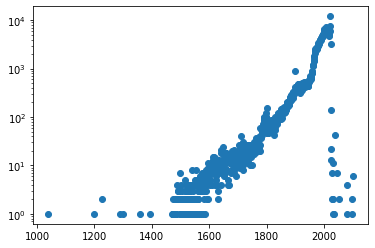

In [50]:
plt.scatter([float(y) for y in years], years.values())
plt.yscale('log')

In [51]:
min(years)

'1039'

In [52]:
[m for m in edition_metadata.values() if '1039' in m.get('publish_date','')]

[{'publishers': ['E. Droz'],
  'series': ['Societe des Textes francais modernes'],
  'covers': [9760480],
  'full_title': "Reveries sur la nature primitive de l'homme",
  'last_modified': {'type': '/type/datetime',
   'value': '2020-05-19T06:55:44.565733'},
  'latest_revision': 3,
  'key': '/books/OL26548376M',
  'authors': [{'key': '/authors/OL127408A'}],
  'ocaid': 'reveriessurlanat0001sena',
  'publish_places': ['Paris'],
  'edition_name': '[2 ed.] ; ed. critique par Joachim Merlant.',
  'pagination': '2 v.',
  'source_records': ['marc:OpenLibraries-Trent-MARCs/tier1.mrc:21119709:627',
   'ia:reveriessurlanat0001sena'],
  'title': "Reveries sur la nature primitive de l'homme",
  'notes': {'type': '/type/text', 'value': 'Vol. 2 edited by G. Saintville.'},
  'created': {'type': '/type/datetime', 'value': '2018-11-15T12:04:43.459477'},
  'languages': [{'key': '/languages/fre'}],
  'local_id': ['urn:trent:0116302388214'],
  'subject_people': ['Joachim Merlant (1875-1919)'],
  'publish_c

## Publishers

The publishers is a list of names

In [53]:
[m['publishers'] for m in edition_metadata.values() if 'publishers' in m][:10]

[['Stationery Office Books'],
 ['Stationery Office Books'],
 ['Elsevier'],
 ['Academic Press Inc.,U.S.'],
 ['Penguin UK'],
 ['Holt Rinehart & Winston'],
 ['[U.S. G.P.O., Supt. of Docs., Congressional Sales Office, distributor]'],
 ['Praeger Publishers'],
 ['Izd-vo MGU'],
 ['Random House Trade']]

In [54]:
publishers_counts = Counter()

for m in tqdm(edition_metadata.values()):
    publishers_counts.update(m.get('publishers', []))
    
publishers_counts.most_common(10)

  0%|          | 0/329009 [00:00<?, ?it/s]

[('Independently Published', 11962),
 ('Taylor & Francis Group', 6102),
 ('Springer', 2780),
 ('CreateSpace Independent Publishing Platform', 2113),
 ('[s.n.]', 2064),
 ('U.S. G.P.O.', 1688),
 ('Cambridge University Press', 1444),
 ('s.n.', 1439),
 ('Oxford University Press', 1386),
 ('Independently published', 1201)]

Publishers are very long tailed; many publishers occur only once

In [55]:
Counter(publishers_counts.values()).most_common(20)

[(1, 86775),
 (2, 13413),
 (3, 5049),
 (4, 2772),
 (5, 1639),
 (6, 1090),
 (7, 735),
 (8, 597),
 (9, 495),
 (10, 341),
 (11, 318),
 (12, 266),
 (13, 220),
 (14, 178),
 (15, 164),
 (16, 128),
 (17, 113),
 (18, 113),
 (19, 100),
 (20, 98)]

And there are many variations of a publishers name; they're not unique.

In [56]:
[(a, c) for a,c in publishers_counts.items() if 'Francis' in a and 'Taylor' in a]

[('Taylor & Francis Group', 6102),
 ('Taylor & Francis', 108),
 ('Taylor & Francis Books Ltd', 8),
 ('Taylor & Francis Inc', 14),
 ('Taylor & Francis Ltd', 19),
 ('Taylor&Francis', 2),
 ('CRC Press, Taylor & Francis Group', 3),
 ('CRC/Taylor & Francis', 5),
 ('Taylor and Francis', 4),
 ('Routledge,an imprint of Taylor & Francis Books Ltd', 2),
 ('CRC Press/Taylor & Francis', 1),
 ('Printed by Taylor and Francis, pub. by the author', 1),
 ('Distributed by Taylor & Francis in USA', 1),
 ('Taylor & Francis A CRC title, part of the Taylor & Francis imprint, a member of the Taylor & Francis Group, the academic division of T&F Informa, plc',
  1),
 ('Taylor & Francis Group Plc', 8),
 ('Routledge, Taylor and Francis Group', 2),
 ('Lawrence Erlbaum Associates /Taylor & Francis Group', 1),
 ('Taylor and Francise', 1),
 ('CRC Press,Taylor & Francis', 1),
 ('CRC Press/Taylor & Francis Group', 1),
 ('Taylor & Francis Publishing', 1),
 ('Taylor & Francis, Inc.', 2),
 ('Distributed in North and Sout

In [57]:
[(a, c) for a,c in publishers_counts.items() if 'Oxford' in a and c>10]

[('Oxford University Press', 1386),
 ('Oxford University Press, Incorporated', 137),
 ('Oxford University Press, USA', 297),
 ('H. Milford, Oxford University Press', 11),
 ('Oxford Brookes University', 41),
 ('Oxford University Press Australia & New Zealand', 18),
 ('Oxford university press', 12),
 ('Oxford U.P.', 19)]

## Created

I *suspect* this was when the record was first created

In [58]:
[(m['created'], m.get('publish_date')) for m in edition_metadata.values() if 'created' in m][:10]

[({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'June 7, 1999'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'December 31, 1992'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'December 31, 1983'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'December 1980'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'June 1999'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'}, '2000'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'December 30, 2006'),
 ({'type': '/type/datetime', 'value': '2008-04-01T03:28:50.625462'}, '1992'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'June 1984'),
 ({'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'}, '1980')]

## Authors

In [59]:
[m['authors'] for m in edition_metadata.values() if 'authors' in m][:10]

[[{'key': '/authors/OL46053A'}],
 [{'key': '/authors/OL46053A'}],
 [{'key': '/authors/OL3365058A'}],
 [{'key': '/authors/OL2657364A'}],
 [{'key': '/authors/OL2661014A'}],
 [{'key': '/authors/OL18485A'}],
 [{'key': '/authors/OL371815A'}],
 [{'key': '/authors/OL1127220A'}],
 [{'key': '/authors/OL3434419A'}],
 [{'key': '/authors/OL894056A'}]]

In [60]:
edition_author_key_counts = Counter()

for m in tqdm(edition_metadata.values()):
    for author in m.get('authors', []):
        edition_author_key_counts.update(list(author))
    
edition_author_key_counts.most_common(10)

  0%|          | 0/329009 [00:00<?, ?it/s]

[('key', 325419)]

What's the frequency of number of authors

In [61]:
edition_author_freq_counts = Counter()

for m in tqdm(edition_metadata.values()):
    edition_author_freq_counts.update([len(m.get('authors', []))])

    
edition_author_freq_counts.most_common(10)

  0%|          | 0/329009 [00:00<?, ?it/s]

[(1, 268703),
 (0, 37783),
 (2, 15146),
 (3, 4800),
 (4, 1499),
 (5, 863),
 (6, 85),
 (8, 34),
 (7, 30),
 (10, 24)]

In [62]:
max(edition_author_freq_counts.keys())

20

In [63]:
m = next(iter(edition_metadata.values()))

In [64]:
[a['author']['key'] for a in work_metadata[m['works'][0]['key']]['authors']]

['/authors/OL2656742A']

In [65]:
[a['key'] for a in m['authors']]

['/authors/OL46053A']

In [66]:
a = set()

In [67]:
a.issubset

<function set.issubset>

Most of the time the work contains at least the authors from the edition

In [68]:
author_work_relationships = {'edition_subset': 0, 'edition_superset': 0, 'disjoint': 0, 'equal': 0}

for m in tqdm(edition_metadata.values()):
    edition_authors = set(a['key'] for a in m.get('authors', []))
    work_authors = set(a['author']['key'] for a in work_metadata[m['works'][0]['key']].get('authors', []) if 'author' in a)
    
    if edition_authors == work_authors:
        relation = 'equal'
    elif edition_authors.issubset(work_authors):
        relation = 'edition_subset'
    elif edition_authors.issuperset(work_authors):
        relation = 'edition_superset'
    else:
        relation = 'disjoint'
        
    author_work_relationships[relation] += 1
        
    
author_work_relationships

  0%|          | 0/329009 [00:00<?, ?it/s]

{'edition_subset': 30640,
 'edition_superset': 4095,
 'disjoint': 3101,
 'equal': 291173}

In [69]:
examples = []

for m in tqdm(edition_metadata.values()):
    edition_authors = set(a['key'] for a in m.get('authors', []))
    work_authors = set(a['author']['key'] for a in work_metadata[m['works'][0]['key']].get('authors', []) if 'author' in a)
    
    
    
    if edition_authors == work_authors:
        relation = 'equal'
    elif edition_authors.issubset(work_authors):
        relation = 'edition_subset'
    elif edition_authors.issuperset(work_authors):
        relation = 'edition_superset'
    else:
        examples.append((m, edition_authors, work_authors))
     
    if len(examples) >= 10:
        break

  0%|          | 0/329009 [00:00<?, ?it/s]

In this example the edition has 2 authors; one is a duplicate of the work author, the other doesn't exist anymore.

In [70]:
examples[3]

({'publishers': ['M P Ediciones S.A.'],
  'number_of_pages': 248,
  'subtitle': 'Manuales Users, en Espanol / Spanish (Manuales Users)',
  'weight': '1 pounds',
  'covers': [3361044],
  'physical_format': 'Paperback',
  'last_modified': {'type': '/type/datetime',
   'value': '2018-08-08T09:23:12.651085'},
  'latest_revision': 6,
  'key': '/books/OL13200210M',
  'authors': [{'key': '/authors/OL4213926A'}, {'key': '/authors/OL3228916A'}],
  'ocaid': 'microsoftaccessx00mari',
  'subjects': ['Desktop Applications - MS Access',
   'General',
   'Operating Systems - General',
   'Database Management - General',
   'Programming Languages - SQL',
   'Programming Languages - Visual BASIC',
   'Computers',
   'Computers - Operating Systems',
   'Spanish: Adult Nonfiction'],
  'isbn_13': ['9789875261082'],
  'source_records': ['ia:microsoftaccessx00mari'],
  'title': 'Microsoft Access XP Manual del Usuario',
  'identifiers': {'goodreads': ['3097572']},
  'created': {'type': '/type/datetime', 'val

The work is "Rand McNally", the edition is "Great Britain.". A strange attribution.

In [71]:
examples[0]

({'publishers': ['Stationery Office Books'],
  'physical_format': 'Paperback',
  'last_modified': {'type': '/type/datetime',
   'value': '2011-04-25T18:22:00.937363'},
  'title': 'The Local Authority (Stocks and Bonds) (Amendment) Regulations 1999 (Statutory Instruments: 1999: 1409)',
  'number_of_pages': 2,
  'created': {'type': '/type/datetime', 'value': '2008-04-30T09:38:13.731961'},
  'isbn_13': ['9780110826684'],
  'isbn_10': ['011082668X'],
  'publish_date': 'June 7, 1999',
  'key': '/books/OL10021723M',
  'authors': [{'key': '/authors/OL46053A'}],
  'latest_revision': 3,
  'oclc_numbers': ['44845380'],
  'works': [{'key': '/works/OL14889469W'}],
  'type': {'key': '/type/edition'},
  'subjects': ['English Law'],
  'revision': 3},
 {'/authors/OL46053A'},
 {'/authors/OL2656742A'})

In [72]:
examples = []

for m in tqdm(edition_metadata.values()):
    edition_authors = set(a['key'] for a in m.get('authors', []))
    work_authors = set(a['author']['key'] for a in work_metadata[m['works'][0]['key']].get('authors', []) if 'author' in a)
    
    
    
    if edition_authors == work_authors:
        relation = 'equal'
    elif edition_authors.issuperset(work_authors):
        examples.append((m, edition_authors, work_authors))
 
    if len(examples) >= 10:
        break

  0%|          | 0/329009 [00:00<?, ?it/s]

Some times the work only contains the main author, and the edition contains secondary authors

In [73]:
examples[4]

({'publishers': ['Taylor & Francis Group'],
  'last_modified': {'type': '/type/datetime',
   'value': '2020-08-25T16:22:46.525595'},
  'source_records': ['bwb:9780429661754'],
  'title': 'Community Psychology',
  'number_of_pages': 558,
  'isbn_13': ['9780429661754'],
  'created': {'type': '/type/datetime', 'value': '2020-08-25T16:22:46.525595'},
  'languages': [{'key': '/languages/eng'}],
  'full_title': 'Community Psychology',
  'lc_classifications': [''],
  'publish_date': '2019',
  'key': '/books/OL29419511M',
  'authors': [{'key': '/authors/OL6601753A'},
   {'key': '/authors/OL8082512A'},
   {'key': '/authors/OL2672695A'},
   {'key': '/authors/OL589289A'}],
  'latest_revision': 1,
  'works': [{'key': '/works/OL13759866W'}],
  'type': {'key': '/type/edition'},
  'subjects': ['Community psychology'],
  'revision': 1},
 {'/authors/OL2672695A',
  '/authors/OL589289A',
  '/authors/OL6601753A',
  '/authors/OL8082512A'},
 {'/authors/OL6601753A'})

## Languages

In [74]:
[m['languages'] for m in edition_metadata.values() if 'languages' in m][:10]

[[{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/rus'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}],
 [{'key': '/languages/eng'}]]

In [75]:
language_freq_counts = Counter()

for m in tqdm(edition_metadata.values()):
    language_freq_counts.update([len(m.get('languages', []))])

    
language_freq_counts.most_common(10)

  0%|          | 0/329009 [00:00<?, ?it/s]

[(1, 282572), (0, 46301), (2, 126), (4, 7), (5, 2), (3, 1)]

Multilingual texts

In [76]:
examples = []

for m in tqdm(edition_metadata.values()):
    if len(m.get('languages', [])) > 1:
        examples.append([m['title'], m['languages']])
    if len(examples) >= 10:
        break

examples

  0%|          | 0/329009 [00:00<?, ?it/s]

[['Basenjis 2008 Square Wall Calendar',
  [{'key': '/languages/ger'},
   {'key': '/languages/fre'},
   {'key': '/languages/spa'},
   {'key': '/languages/eng'}]],
 ['Poema del Cid', [{'key': '/languages/eng'}, {'key': '/languages/spa'}]],
 ['Pride and Prejudice',
  [{'key': '/languages/chi'}, {'key': '/languages/eng'}]],
 ['Chonguk toro kwangwang chido =: Road maps to tourist attractions in Korea ',
  [{'key': '/languages/kor'}, {'key': '/languages/eng'}]],
 ['Chagall and the Bible',
  [{'key': '/languages/eng'}, {'key': '/languages/ita'}]],
 ['Spanish Berlitz Compact Dictionary (Berlitz Compact Dictionaries)',
  [{'key': '/languages/eng'}, {'key': '/languages/spa'}]],
 ['Griechische und süditalienische Gebete, Beschwörungen und Rezepte des Mittelalters',
  [{'key': '/languages/ger'}, {'key': '/languages/grc'}]],
 ['Tragedias', [{'key': '/languages/spa'}, {'key': '/languages/grc'}]],
 ['傲慢与偏见', [{'key': '/languages/chi'}, {'key': '/languages/eng'}]],
 ['A vocabulary, English and Greek',

Most common languages; includes latin (`lat`)

In [77]:
language_count = Counter()

for m in tqdm(edition_metadata.values()):
    language_count.update([a['key'] for a in m.get('languages', [])])

    
language_count.most_common(15)

  0%|          | 0/329009 [00:00<?, ?it/s]

[('/languages/eng', 189369),
 ('/languages/ger', 16483),
 ('/languages/fre', 14165),
 ('/languages/spa', 12451),
 ('/languages/rus', 6089),
 ('/languages/chi', 5265),
 ('/languages/ita', 5104),
 ('/languages/jpn', 3852),
 ('/languages/por', 2550),
 ('/languages/ara', 2477),
 ('/languages/pol', 1583),
 ('/languages/kor', 1527),
 ('/languages/dut', 1363),
 ('/languages/heb', 1278),
 ('/languages/lat', 1178)]

In [78]:
len(language_count)

252

## Number of Pages

In [79]:
[m['number_of_pages'] for m in edition_metadata.values() if 'number_of_pages' in m][:10]

[2, 396, 99, 32, 119, 1400, 238, 164, 96, 584]

## Source Records

In [80]:
[m['source_records'] for m in edition_metadata.values() if 'source_records' in m][:10]

[['bwb:9780120812004'],
 ['ia:interferon0000unse'],
 ['ia:rajincharge0000davi'],
 ['amazon:0160612519'],
 ['marc:marc_claremont_school_theology/CSTMARC2_barcode.mrc:53646163:8461',
  'marc:marc_loc_2016/BooksAll.2016.part33.utf8:130303161:1643',
  'marc:marc_claremont_school_theology/CSTMARC2_multibarcode.mrc:53667752:8573',
  'ia:voicesofislam0000unse_r7b1',
  'ia:voicesofislam0001unse',
  'ia:voicesofislam0004unse',
  'ia:voicesofislam0000unse',
  'ia:voicesofislam0003unse',
  'bwb:9780275987329'],
 ['marc:marc_loc_2016/BooksAll.2016.part23.utf8:71148954:660'],
 ['bwb:9780318424460'],
 ['marc:talis_openlibrary_contribution/talis-openlibrary-contribution.mrc:619778603:547',
  'ia:philipsconciseat0000unse'],
 ['marc:marc_loc_2016/BooksAll.2016.part23.utf8:119547990:732'],
 ['bwb:9780757505621']]

I would guess the sources are:

* `marc` is MARC 21 exports (from where?)
* `bwb` is Better World Books
* `ia` is Internet Archive
* `amazon` is from an Amazon listing page

In [81]:
source_count = Counter()

for m in tqdm(edition_metadata.values()):
    sources = set(a.split(':')[0] for a in m.get('source_records', []) if ':' in a)
    source_count.update(sources)
    
    
source_count.most_common(5)

  0%|          | 0/329009 [00:00<?, ?it/s]

[('marc', 126485),
 ('bwb', 75873),
 ('ia', 46612),
 ('amazon', 27853),
 ('marc_overdrive/InternetArchiveCrMarc-2010-06-11c.mrc', 36)]

In [82]:
source_count = Counter()

for m in tqdm(edition_metadata.values()):
    sources = set(a.split(':')[0] for a in m.get('source_records', []) if ':' in a)
    source_count.update(sources)
    
    
source_count.most_common(5)

  0%|          | 0/329009 [00:00<?, ?it/s]

[('marc', 126485),
 ('bwb', 75873),
 ('ia', 46612),
 ('amazon', 27853),
 ('marc_overdrive/InternetArchiveCrMarc-2010-06-11c.mrc', 36)]

I would expect they would cover different periods; for example Internet Archive would mainly be public domain works

In [83]:
source_years = {k: Counter() for k in ['marc', 'bwb', 'ia', 'amazon']}

for m in tqdm(edition_metadata.values()):
    for source in set(a.split(':')[0] for a in m.get('source_records', []) if ':' in a):
        year_match = re.search(r'\b[12][0-9]{3}\b', m.get('publish_date', ''))
        if year_match and source in source_years:
            source_years[source].update([int(year_match.group(0))])

  0%|          | 0/329009 [00:00<?, ?it/s]

Marc doesn't contain many publications after 2009

In [84]:
source_years['marc'].most_common(5)

[(2009, 3333), (2008, 3082), (2007, 2941), (2010, 2935), (2005, 2698)]

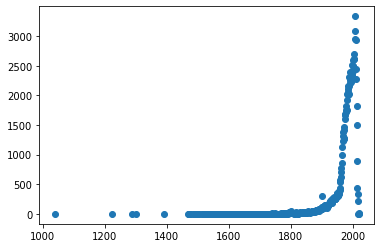

In [85]:
plt.scatter(source_years['marc'].keys(), source_years['marc'].values())

Better world books contains some books published from the future (data errors?), but most of the most current items.

In [86]:
source_years['bwb'].most_common(5)

[(2021, 11296), (2020, 6777), (2019, 4001), (2018, 3425), (2013, 3413)]

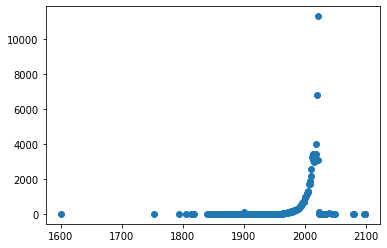

In [87]:
plt.scatter(source_years['bwb'].keys(), source_years['bwb'].values())

Internet Archive peaks around 2007

In [88]:
source_years['ia'].most_common(5)

[(2007, 1093), (2006, 1080), (2008, 1037), (2005, 1031), (2003, 1000)]

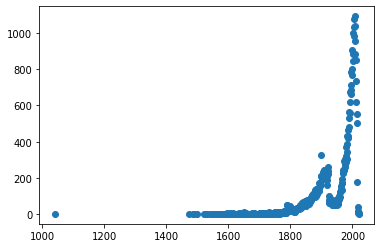

In [89]:
plt.scatter(source_years['ia'].keys(), source_years['ia'].values())

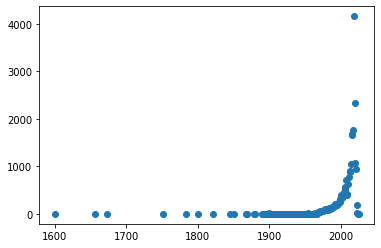

In [90]:
plt.scatter(source_years['amazon'].keys(), source_years['amazon'].values())

## Pagination

Pages with frontmatter

In [91]:
[m['pagination'] for m in edition_metadata.values() if 'pagination' in m][:10]

['238, [1] p. ;',
 'v, 126 p. :',
 '224 p. ;',
 '452 p. ;',
 '33 p. ;',
 'iv, 63 p. :',
 '111 p. ;',
 '244 p. ;',
 '5 p. l., 3-268 p.',
 '3 v. ;']

## Publish Places, Publish Country

I guess where the edition was published

In [92]:
[m['publish_places'] for m in edition_metadata.values() if 'publish_places' in m][:10]

[['Moskva'],
 ['Plano, Tex'],
 ['Minneapolis, Minn'],
 ['Buenos Aires'],
 ['[New Zealand]'],
 ['[Des Moines]'],
 ['[Augusta, Me.]'],
 ['[Jaén]'],
 ['New York'],
 ['Albany, N.Y']]

Apparently `nyu` is New York (state), `txu` is Texas, `mnu` is Minnesota; it seems a US state is considered a country... https://www.loc.gov/marc/countries/countries_code.html

`ag` is Argentina, `sp` is Spain

In [93]:
[m['publish_country'] for m in edition_metadata.values() if 'publish_country' in m][:10]

['ru ', 'txu', 'mnu', 'ag ', 'xxu', 'iau', 'meu', 'sp ', 'nyu', 'nyu']

## Subjects, Subject Places, Subject Time, LC Classifications, Covers

Same as subjects for works. We could check how they relate to works as we did for Authors, and how they change between editions for the same work.

## isbn_13, isbn_10

What it says on the tin; we can convert an ISBN13 to an ISBN10 and vice versa

In [94]:
[(m.get('isbn_13'), m.get('isbn_10')) for m in edition_metadata.values() if 'isbn_13' in m or 'isbn_10' in m][:10]

[(['9780110826684'], ['011082668X']),
 (['9780117293557'], ['0117293555']),
 (['9780120812004'], ['0120812002']),
 (['9780123022516'], ['0123022517']),
 (['9780140381597'], ['0140381597']),
 (['9780155128460'], ['0155128469']),
 (['9780160612510'], ['0160612519']),
 (['9780275987329'], ['0275987329']),
 (None, ['5211022351']),
 (['9780517701003'], ['0517701006'])]

There are a large proportion of cases where we could fill in the ISBN 13 or ISBN 10

In [95]:
isbn_count = {'none':0, 'both': 0, '10': 0, '13': 0}

for m in edition_metadata.values():
    if 'isbn_13' in m and 'isbn_10' in m:
        isbn_count['both'] += 1 / len(edition_metadata)
    elif 'isbn_13' in m:
        isbn_count['13'] +=  1 / len(edition_metadata)
    elif 'isbn_10' in m:
        isbn_count['10'] += 1 / len(edition_metadata)
    else:
        isbn_count['none'] += 1 / len(edition_metadata)

isbn_count

{'none': 0.35705102292075075,
 'both': 0.2666340434454596,
 '10': 0.18079444635246605,
 '13': 0.19552048728139523}

## By Statement

The specifics of how it's attributed

In [96]:
[m['by_statement'] for m in edition_metadata.values() if 'by_statement' in m][:10]

['N.N. Kokhtev.',
 'Eugene W. Teglovic.',
 'Kay Arthur, Jill Briscoe, Carole Mayhall.',
 'Elena I. Highton ... [et al.].',
 'principal researcher and author, David Huff.',
 'Maine State Housing Authority.',
 'Carmelo Medina Casado, Concepción Soto Palomo, editores ; [prólogo, Adolfo Sánchez Rodrigo].',
 'translated with an introduction by Edwin Björkman.',
 'by William Lansing.',
 'Published by the Bureau of Statistics, Agriculture and Immigration.']

## Notes

In [97]:
[m['notes'] for m in edition_metadata.values() if 'notes' in m][:10]

[{'type': '/type/text', 'value': 'First Young Puffin'},
 {'type': '/type/text',
  'value': 'Includes bibliographical references (p. 236-[239]).'},
 {'type': '/type/text', 'value': 'World Country Study Guide Library'},
 {'type': '/type/text', 'value': 'Includes index.'},
 {'type': '/type/text', 'value': 'Diskette for Macintosh'},
 {'type': '/type/text',
  'value': 'Includes bibliographical references (p. [447]-452).\nRev. ed. of: Nuevas formas de dominio / Elena I. Highton, Luis Alvarez Juliá, Susana Lambois. 1. ed. 1987.'},
 {'type': '/type/text', 'value': '"December, 1992"--Cover.'},
 {'type': '/type/text',
  'value': 'At head of title: State of Maine.\n"December 1993."'},
 {'type': '/type/text', 'value': 'Ueda Kaoru chosakushu'},
 {'type': '/type/text', 'value': 'Lernmaterialien'}]

Sometimes notes is a string

In [98]:
Counter(type(m['notes']) for m in edition_metadata.values() if 'notes' in m)

Counter({dict: 137971, str: 1287})

They're all text

In [99]:
c = Counter()

for m in edition_metadata.values():
    if 'notes' in m and isinstance(m['notes'], dict):
        c.update([m['notes']['type']])
        
c.most_common(10)

[('/type/text', 137971)]

## Subtitle, Full Title, Other Titles, Title Prefix, Work Titles

In [100]:
[(m.get('title'), m.get('subtitle'), m.get('full_title'), m.get('other_titles'), m.get('title_prefix'), m.get('work_titles'))
 for m in edition_metadata.values() if 'subtitle' in m][:10]

[('Defense Security Service oversight',
  'Hearing before the Subcommittee on National Security, Veterans Affairs, and International Relations of the Committee ... Congress, second session, February 16, 2000',
  None,
  None,
  None,
  None),
 ('Folklore in Action',
  'Essays for Discussion in Honor of MacEdward Leach',
  None,
  None,
  None,
  None),
 ('Electrical Papers',
  'By Oliver Heaviside. In Two Volumes. Volume 1',
  None,
  None,
  None,
  None),
 ('Quattro Pro 5.0 at a glance',
  'the fastest and easiest way to learn Quattro Pro 5.0 for DOS',
  None,
  None,
  None,
  None),
 ('Poetry Express: O Frabjous Day: Year 3 & 4',
  "Teacher's Handbook (Poetry Express)",
  None,
  None,
  None,
  None),
 ('Can a busy Christian develop her spiritual life?',
  'answers to questions women ask about spirituality',
  None,
  None,
  None,
  None),
 ('Games by Thiagi', 'More Instr Puz', None, None, None, None),
 ('Studies in Symbolic Interaction',
  'A Research Annual 1986/Part A and Part

The full title is often the combination of title and subtitle

In [101]:
[(m.get('title'), m.get('subtitle'), m.get('full_title'), m.get('other_titles'), m.get('title_prefix'), m.get('work_titles'))
 for m in edition_metadata.values() if 'full_title' in m][:10]

[('Traité des membranes en général et de diverses membranes en particulier',
  None,
  'Traité des membranes en général et de diverses membranes en particulier',
  None,
  None,
  None),
 ('Wiedergefundenes Leben',
  '20 Jahre in den Klauen von Alkohol und Tabletten',
  'Wiedergefundenes Leben 20 Jahre in den Klauen von Alkohol und Tabletten',
  None,
  None,
  None),
 ('Erinnerungen an Rudolf Steiner und die Fortbildungsschule am Goetheanum (1921 - 1928)',
  None,
  'Erinnerungen an Rudolf Steiner und die Fortbildungsschule am Goetheanum (1921 - 1928)',
  None,
  None,
  None),
 ('Le 11e regiment de dragons portes dans les combats sur la position de couverture',
  'bataille de la Petite Gette, 10 mai-13 mai 1940',
  'Le 11e regiment de dragons portes dans les combats sur la position de couverture bataille de la Petite Gette, 10 mai-13 mai 1940',
  None,
  None,
  None),
 ('Kommt!  Unsere karawane heisst nicht verzweiflung"',
  None,
  'Kommt!  Unsere karawane heisst nicht verzweiflung

In [102]:
[(m.get('title'), m.get('subtitle'), m.get('full_title'), m.get('other_titles'), m.get('title_prefix'), m.get('work_titles'))
 for m in edition_metadata.values() if 'other_titles' in m][:10]

[('II Jornadas de Estudios Ingleses',
  '13 al 16 de noviembre de 1996',
  None,
  ['2. Jornadas de Estudios Ingleses',
   'Segunda[s] Jornadas de Estudios Ingleses',
   'Jornadas de Estudios Ingleses'],
  None,
  None),
 ('Plays by August Strindberg.',
  '[First series]: The dream play, The link, The dance of death, part I, The dance of death, part II',
  None,
  ['Dream play', 'Link', 'Dance of death'],
  None,
  None),
 ("A panorama of the world's legal systems",
  None,
  None,
  ["World's legal systems."],
  None,
  None),
 ('Construction mechanic 1 & C',
  None,
  None,
  ['Rate training manual'],
  None,
  None),
 ('The countrey gaugers vade mecvm, or, Pocket-companion',
  'being decimal tables for the speedy gauging of small brewing vessels either of a circular, elliptical, or rectilineal base : and also for the gauging of cask in ale or wine measure, either full or part empty : also the description and use of an instrument for the gauging of small brewing vessels',
  None,
  [

It's pretty uncommon to use a `title_prefix` and it doesn't combine them in a `full_title`

In [103]:
[(m.get('title'), m.get('subtitle'), m.get('full_title'), m.get('other_titles'), m.get('title_prefix'), m.get('work_titles'))
 for m in edition_metadata.values() if 'title_prefix' in m][:10]

[('religion of the future', None, None, None, 'The ', None),
 ('Venice notebook', None, None, None, 'The ', None),
 ('dandy del Hotel Savoy', None, None, None, 'El ', None),
 ("inganno de gl'occhi.", None, None, None, 'Lo ', None),
 ('effect of different scouring and rinsing treatments on the colour of scoured wool.',
  None,
  None,
  None,
  'The ',
  None),
 ('amending of the Federal Constitution', None, None, None, 'The ', None),
 ('proposed undergraduate curriculum for the professional preparation of school health educators in Malaysia',
  None,
  None,
  None,
  'A ',
  None),
 ('industrie pharmaceutique', None, None, None, "L'", None),
 ('study of new optical materials',
  'I. Crystal-chemical development of new optical frequency converters II. New hosts for Cr3+ luminescence and lasing',
  None,
  None,
  'A ',
  None),
 ('verts paradis', 'roman.', None, None, 'Les ', None)]

Work titles often seems relevant for editions in different languages

In [104]:
[(m.get('title'), m.get('subtitle'), m.get('full_title'), m.get('other_titles'), m.get('title_prefix'), m.get('work_titles'))
 for m in edition_metadata.values() if 'work_titles' in m][:10]

[('Il talismano', None, None, None, None, ['Talisman.']),
 ('Duma i uprzedzenie',
  None,
  None,
  ['Pride and Prejudice'],
  None,
  ['Pride and prejudice.']),
 ('Oeuvres complètes de M. de Lamartine.', None, None, None, None, ['Works']),
 ('Convention between Her Majesty and the King of the Belgiansenabling their respective Post Offices to make postal arrangements, signed at Brussells, January 8, 1857.',
  None,
  None,
  None,
  None,
  ['Treaties, etc.']),
 ('first crossing of Greenland',
  None,
  None,
  None,
  'The ',
  ['Paa ski over Grønland.']),
 ('Gleichgewicht der Welt', 'Roman', None, None, 'Das ', ['Fine balance.']),
 ('Sobranie sochineniĭ v dvenadtsati tomakh',
  None,
  None,
  None,
  None,
  ['Works']),
 ('money market',
  None,
  None,
  None,
  'The ',
  ['Banche e il mercato monetario.']),
 ('Tagungsbericht und wissenschaftliche Abhandlungen.',
  None,
  None,
  None,
  None,
  ['Deutscher Geographentag']),
 ('Strategic plan 2006-2010',
  None,
  None,
  None,


## LCCN, OCLC, OCAID

Library of Congress Control Numbers

In [105]:
[m['lccn'] for m in edition_metadata.values() if 'lccn' in m][:10]

[['2006031060'],
 ['93236615'],
 ['94006337'],
 ['94027806'],
 ['00105552'],
 ['2001118532'],
 ['94175581'],
 ['94242124'],
 ['94620082'],
 ['94621686']]

[OCLC Numbers](https://help.oclc.org/Metadata_Services/WorldShare_Collection_Manager/Data_sync_collections/Prepare_your_data/30035_field_and_OCLC_control_numbers)

In [106]:
[m['oclc_numbers'] for m in edition_metadata.values() if 'oclc_numbers' in m][:10]

[['44845380'],
 ['43183151'],
 ['45544818'],
 ['29379986'],
 ['9703110'],
 ['316548975'],
 ['29953070'],
 ['648935664'],
 ['30916430'],
 ['30734335']]

Internet Archive e.g. https://archive.org/details/interferon0000unse

In [107]:
[m['ocaid'] for m in edition_metadata.values() if 'ocaid' in m][:10]

['interferon0000unse',
 'rajincharge0000davi',
 'voicesofislam0000unse_r7b1',
 'philipsconciseat0000unse',
 'conversationsave0000litt',
 'tracerhydrologyp0000inte',
 'microsoftaccessx00mari',
 'formsofcivilproc02lans',
 'agriculturalmanu00wash',
 'religionoffuture00elio']

## Identifiers

Links to other resources

In [108]:
[m['identifiers'] for m in edition_metadata.values() if 'identifiers' in m][:10]

[{'goodreads': ['5945087']},
 {'librarything': ['6457272']},
 {'goodreads': ['288665'], 'librarything': ['4307547']},
 {'goodreads': ['1715461']},
 {},
 {'librarything': ['5391523']},
 {},
 {'goodreads': ['5870746']},
 {'librarything': ['740747'], 'goodreads': ['494437']},
 {'goodreads': ['6160082']}]

Mostly to goodreads and librarything, with some to amazon.

In [109]:
identifier_source_counts = Counter()

for m in edition_metadata.values():
    if 'identifiers' in m:
        identifier_source_counts.update(list(m['identifiers']))
        
identifier_source_counts.most_common(15)

[('goodreads', 61813),
 ('librarything', 41339),
 ('amazon', 4681),
 ('overdrive', 786),
 ('dnb', 223),
 ('wikidata', 193),
 ('google', 174),
 ('amazon.co.uk_asin', 149),
 ('depósito_legal', 117),
 ('amazon.de_asin', 99),
 ('amazon.ca_asin', 70),
 ('amazon.it_asin', 44),
 ('alibris_id', 37),
 ('canadian_national_library_archive', 29),
 ('british_library', 20)]

## Physical Format

In [110]:
[m['physical_format'] for m in edition_metadata.values() if 'physical_format' in m][:10]

['Paperback',
 'Paperback',
 'Hardcover',
 'Hardcover',
 'Paperback',
 'Hardcover',
 'Unknown Binding',
 'Hardcover',
 'Library Binding',
 'Hardcover']

There's some case normalisation issues here.

It's almost entirely hard copies.

In [111]:
identifier_source_counts = Counter()

for m in edition_metadata.values():
    if 'physical_format' in m:
        identifier_source_counts.update([m['physical_format']])
        
identifier_source_counts.most_common(15)

[('Paperback', 26915),
 ('paperback', 13715),
 ('Hardcover', 13144),
 ('Microform', 7756),
 ('hardcover', 4532),
 ('Unknown Binding', 4000),
 ('Electronic resource', 1647),
 ('Mass Market Paperback', 845),
 ('Ring-bound', 623),
 ('audio cd', 476),
 ('Audio Cassette', 471),
 ('Library Binding', 457),
 ('Audio CD', 415),
 ('Spiral-bound', 373),
 ('eBook', 343)]

## Contributions

Adaptations, editors, illustrators. Unstructured

In [112]:
[m['contributions'] for m in edition_metadata.values() if 'contributions' in m][:10]

[['Virginia Gray Henry-Blakemore (Adapter)',
  'Omid Safi (Adapter)',
  'Vincent J. Cornell (Editor)'],
 ['Briscoe, Jill.', 'Mayhall, Carole.'],
 ['Highton, Elena I.', 'Highton, Elena I.'],
 ['Lawrence F. Abbott (Editor)'],
 ['New Zealand. Ministry for the Environment.'],
 ['Iowa. Division of Criminal and Juvenile Justice Planning.'],
 ['Medina Casado, Carmelo.', 'Soto Palomo, Concepción.'],
 ['Illustrated (Illustrator)'],
 ['Björkman, Edwin, 1866-1951, tr.'],
 ['Washington (State). Bureau of Statistics, Agriculture and Immigration.']]

## Series

In [113]:
[m['series'] for m in edition_metadata.values() if 'series' in m][:10]

[['Its Report -- 1903'],
 ['Strategic forum -- no. 101'],
 ['Colección Teatro breve'],
 ['Loeb classical library. [Greek authors]', 'Loeb classical library'],
 ['Research note SO -- 359.'],
 ['Research publication series / Ministry of Higher Education, Republic of Sri Lanka',
  'Research publication series (Sri Lanka. Usas Adhyāpana Amātyaṃśaya)'],
 ['Theses'],
 ['Acta universitatis stockholmiensis -- 13'],
 ['Statistika dlya vsekh'],
 ['The printed sources of Western art -- 14']]

## Weight, Physical Dimensions

Weight as a description

In [114]:
[m['weight'] for m in edition_metadata.values() if 'weight' in m][:10]

['6.8 pounds',
 '1.7 pounds',
 '1 pounds',
 '1.1 pounds',
 '1.7 pounds',
 '7.2 ounces',
 '9.3 ounces',
 '11.2 ounces',
 '2.6 pounds',
 '6.9 ounces']

Size as a description

In [115]:
[m['physical_dimensions'] for m in edition_metadata.values() if 'physical_dimensions' in m][:10]

['9.9 x 7 x 5.8 inches',
 '37 x 8.2 x 5.2 inches',
 '8.2 x 5.2 x 0.8 inches',
 '9.1 x 6.1 x 0.8 inches',
 '11.5 x 7.9 x 0.2 inches',
 '8.3 x 5.5 x 0.5 inches',
 '9.5 x 6.5 x 2.2 inches',
 '20 x 20 x 20 inches',
 '11.1 x 8.3 x 0.3 inches',
 '9.4 x 6.1 x 0.8 inches']

## Genres

Broader than other classifications

In [116]:
[m['genres'] for m in edition_metadata.values() if 'genres' in m][:10]

[['Congresses.'],
 ['Forms.'],
 ['Statistics.'],
 ['Catalogs.'],
 ['Statistics.'],
 ['Correspondence.'],
 ['Catalogs.'],
 ['Drama.'],
 ['Poetry.'],
 ['Statistics.']]

In [117]:
genre_counts = Counter()

for m in edition_metadata.values():
    genre_counts.update(m.get('genres', []))
    
genre_counts.most_common(10)

[('Biography.', 1555),
 ('Fiction.', 1511),
 ('Congresses.', 1112),
 ('Juvenile literature.', 565),
 ('Exhibitions.', 536),
 ('Biography', 526),
 ('Early works to 1800.', 395),
 ('Bibliography.', 373),
 ('Catalogs.', 338),
 ('Statistics.', 251)]

## Description

Something like a blurb

In [118]:
[m['description'] for m in edition_metadata.values() if 'description' in m][:10]

[{'type': '/type/text',
  'value': 'Study on traditional axe used by shifting cultivation people in Betung and Sorek Villages, Kecamatan Pangkalan Kuras, Kabupaten Kampar, Riau Province.'},
 {'type': '/type/text',
  'value': 'Considers legislation to revise regulations in matters related to railroad train crew sizes, boiler inspection procedures, and yard maintenance measures\n\nConsiders (61) H.R. 22066, (61) S. 6702, (61) H.R. 25924, (61) H.R. 16879, (61) H.R. 16880, (61) H.R. 16881'},
 {'type': '/type/text',
  'value': 'About the Burmese minister Vanʻ jaṅʻʺ Maṅʻʺ Rājā, 1392-1466.'},
 {'type': '/type/text', 'value': 'Committee Serial No. 58'},
 {'type': '/type/text',
  'value': 'Isaac, nacido en 1970, hijo de Moisés y de Amparo, se considera descendiente de los judíos sefardíes expulsados de España en 1492. Tras morir su esposa, el librero Moisés debe educar en solitario a Isaac, que se interesa por su pasado a la vez que se acostumbra a convivir con gentes diversas. Al llegar a 

## Local id

Look like links to other catalogues?

In [119]:
[(m.get('title'), m['local_id']) for m in edition_metadata.values() if 'local_id' in m][:5]

[('Voices of Islam [Five Volumes]',
  ['urn:cst:10017030842',
   'urn:cst:10017030848',
   'urn:cst:10017030854',
   'urn:cst:10017030860',
   'urn:cst:10017030866']),
 ('Can a busy Christian develop her spiritual life?',
  ['urn:evs:39663100284140']),
 ('Tracer Hydrology', ['urn:trent:0116403979903']),
 ('Foundations of the Christian Way of Life According to 1 Peter 1, 13-25',
  ['urn:cst:10011457656']),
 ('Popping fuchsias', ['urn:trent:0116402773380'])]

## URL

A lot of these links are broken...

In [120]:
[(m.get('title'), m['url']) for m in edition_metadata.values() if 'url' in m][:5]

[('Romania and NATO',
  ['http://www.ndu.edu/inss/strforum/SF101/forum101.html']),
 ('Big trees of the midsouth forest survey',
  ['http://purl.version.gpo.gov/GPO/LPS82477']),
 ('Achievement and motivation',
  ['http://www.loc.gov/catdir/toc/cam051/91043220.html',
   'http://www.loc.gov/catdir/description/cam024/91043220.html']),
 ('Owner of tug William Alexander.',
  ['https://proxy.lib.muohio.edu/login?source=opac&url=http://www.lexisnexis.com/congcomp/getdoc?SERIAL-SET-ID=3272+H.rp.1252']),
 ('Martha McAfee.',
  ['https://proxy.lib.muohio.edu/login?source=opac&url=http://www.lexisnexis.com/congcomp/getdoc?SERIAL-SET-ID=4761+H.rp.3677'])]

## Table of Contents

In [121]:
[(m.get('title'), m['table_of_contents']) for m in edition_metadata.values() if 'table_of_contents' in m][:5]

[('Early Spanish Choral Music',
  [{'type': '/type/text',
    'value': 'Contents: Pastores, Dicite Quidnam Vidistis / by Christobal de Morales, - Ecce Virgo Concipiet / by Christobal de Morales, - o Vos Omnes / by de Esquivel, - Ecce nunc Tempus / by Francisco Guerrero, - Missus est Gabriel / by Christobal de Morales, - Vamos al Portal / by Francisco Guerrero, - o Quam Gloriosum / by Juan de Esquivel, - o Magnummysterium / by Christobal de Morales.'}]),
 ('Tratado de derecho comparativo',
  [{'level': 0,
    'type': {'key': '/type/toc_item'},
    'title': 'v. 2. El método comparativo'}]),
 ('Inhibition of chain reactions',
  ['Pt. 1. Straight chain reactions: Fundamentals of the theory of chain reactions. Inhibition of straight chain reactions in the gas phase. Inhibitors of polymerization. Kinetics of the inhibited chain oxidation of organic compounds. Inhibition of oxidation by phenols and aromatic amines. Cyclic mechanisms of chain termination upon oxidation of organic compounds',


## First Sentence

In [122]:
[(m.get('title'), m['first_sentence']) for m in edition_metadata.values() if 'first_sentence' in m][:5]

[('Edith Wharton (Women Writers)',
  {'type': '/type/text',
   'value': 'Edith Wharton awoke in the morning before her husband and guests.'}),
 ('Miss Brown',
  {'type': '/type/text',
   'value': "WHILE Anne was being indoctrinated with her cousin's philosophical theories, Hamlin had little by little let himself be drawn into the little clique of more mystical and Bohemian pre-Raphaelites whom Edmund Lewis had collected round Madame Elaguine."}),
 ('The escape of Marvin the ape',
  {'type': '/type/text',
   'value': "It was feeding time, and when the zookeeper wasn't looking, Marvin... slipped out."}),
 ("La Philosophie D'un Anti-philosophe (Zaharoff Lectures)",
  {'type': '/type/text', 'value': 'Institutions are the bedrock of society.'}),
 ('Sunday Morning',
  {'type': '/type/text',
   'value': 'Last night my mother and father came home late.'})]

## Classifications

In [123]:
[(m.get('title'), m['classifications']) for m in edition_metadata.values() if m.get('classifications')][:5]

[('The Annotated Pride and Prejudice',
  {'lccn_permalink': ['https://lccn.loc.gov/2012025584']}),
 ('The Annotated Pride and Prejudice',
  {'lccn_permalink': ['https://lccn.loc.gov/2006049949']}),
 ("Elmo's World Babies!",
  {'lccn_permalink': ['https://lccn.loc.gov/99066885']}),
 ('Pride and Prejudice',
  {'lccn_permalink': ['https://lccn.loc.gov/2008277621']}),
 ('Libelli', {'identificativo_sbn': ['IT\\ICCU\\CUB\\0218304']})]

# Authors

In [124]:
author_key_counts = Counter()

for m in tqdm(author_metadata.values()):
    author_key_counts.update(m.keys())

{k:v/len(author_metadata) for k,v in author_key_counts.most_common() if v/len(author_metadata) > 0.01}

  0%|          | 0/230841 [00:00<?, ?it/s]

{'type': 1.0,
 'key': 1.0,
 'revision': 1.0,
 'last_modified': 1.0,
 'name': 0.9999956680139144,
 'personal_name': 0.6213757521410841,
 'created': 0.4581681763638175,
 'latest_revision': 0.3775932351705286,
 'birth_date': 0.22452250683370806,
 'death_date': 0.08824688855099397,
 'source_records': 0.08777037008157129,
 'remote_ids': 0.07237015954704754,
 'alternate_names': 0.04473208832053231,
 'photos': 0.02413782646930138,
 'bio': 0.01831563717017341,
 'title': 0.014347537915708215}

## Name, personal_name, alternate_names, title

Seems inconsistent in name format

In [125]:
[(m.get('name'),
  m.get('personal_name'),
  m.get('alternate_names'),
  m.get('title'),
 )
  for m in author_metadata.values() if m.get('personal_name')][:5]

[('Dilwyn Jenkins', 'Dilwyn Jenkins', None, None),
 ('John Walmsley', 'John Walmsley', None, None),
 ('Ruth Schroeder', 'Ruth Schroeder', None, None),
 ('Ping, Weiying Nü', 'Ping, Weiying', None, 'Nü'),
 ('Bolesław Mikołajczak', 'Bolesław Mikołajczak', None, None)]

In [126]:
[(m.get('name'),
  m.get('personal_name'),
  m.get('alternate_names'),
  m.get('title'),
 )
  for m in author_metadata.values() if m.get('alternate_names')][:5]

[('Jean Ingelow',
  'Ingelow, Jean',
  ['Ingelow, Jean', 'Poems by Jean Ingelow'],
  None),
 ('Margaret Olwen Macmillan',
  'Margaret Olwen Macmillan',
  ['Professor Margaret MacMillan',
   'Margaret MacMillan',
   'Margaret Macmillan',
   'Margaret MacMillian',
   'Margaret / Marjorie H arris & Anne L. Desjardins in Conversation with Adrienne Clarkson and John Ralston Saul MacMillan'],
  None),
 ('Ernest Renan',
  'Ernest Renan',
  ['Ernest Rénan',
   'E. Renan',
   'Joseph Ernest Renan',
   'Renan',
   'M. Ernest Renan'],
  None),
 ('George Ernest Wright',
  'George Ernest Wright',
  ['G. Ernest Wright', 'Wright, George Ernest, 1909-1974'],
  None),
 ('Venezuela.', None, ['Venezuela'], None)]

In [127]:
[(m.get('name'),
  m.get('personal_name'),
  m.get('alternate_names'),
  m.get('title'),
 )
  for m in author_metadata.values() if m.get('title')][:5]

[('Ping, Weiying Nü', 'Ping, Weiying', None, 'Nü'),
 ('Singh, Swaran Ph.D.', 'Singh, Swaran', None, 'Ph.D.'),
 ('Sir John Francis Davis',
  'Davis, John Francis',
  ['Davis, John Francis Sir, bart', 'Davis, John Francis Sir'],
  'Sir'),
 ('Thomas Cranmer',
  'Thomas Cranmer',
  ['Cranmer, Thomas Abp. of Canterbury', 'Cranmer, Thomas abp. of Canterbury'],
  'Abp. of Canterbury'),
 ('Cavagna Sangiuliani di Gualdana, Antonio conte',
  'Cavagna Sangiuliani di Gualdana, Antonio',
  None,
  'conte')]

## birth_date, death_date

A date is a human readable string

In [128]:
[(m.get('name'), m.get('birth_date'), m.get('death_date')
 )
  for m in author_metadata.values() if m.get('death_date')][:5]

[('Jean Ingelow', '1820', '1897'),
 ('Guthrie, William', '1708', '1770'),
 ('Ernest Renan', '28 February 1823', '2 October 1892'),
 ('Barbara E. Ward', None, '1983'),
 ('Paul Louis', '1872', '1948')]

## source_records

Where the data came from; here often Better World Books

In [129]:
[(m.get('name'), m.get('source_records')
 )
  for m in author_metadata.values() if m.get('source_records')][:5]

[('Rizky Ranny Andayani', ['bwb:9798645250430']),
 ('Brenda Cartujano-Barrera', ['bwb:9780578256108']),
 ('D. Battaglia', ['bwb:9789251335338']),
 ('Gaurie Dwivedi', ['bwb:9789390095414']),
 ('Orest Publishing', ['bwb:9798751008284'])]

Similar to book sources.

This could be a potential source of duplicates.

In [130]:
Counter(a.split(':')[0] for m in author_metadata.values() for a in m.get('source_records', [])).most_common(5)

[('bwb', 11002),
 ('amazon', 7601),
 ('ia', 1839),
 ('marc', 1745),
 ('pressbooks', 13)]

## remote_ids

In [131]:
[(m.get('name'), m.get('remote_ids')
 )
  for m in author_metadata.values() if m.get('remote_ids')][:5]

[('Jean Ingelow',
  {'viaf': '28265826', 'wikidata': 'Q467915', 'isni': '0000000083425290'}),
 ('Guthrie, William',
  {'viaf': '100194070', 'wikidata': 'Q8010287', 'isni': '0000000110792193'}),
 ('Margaret Olwen Macmillan',
  {'viaf': '66698923', 'wikidata': 'Q518615', 'isni': '0000000109111493'}),
 ('Ernest Renan',
  {'wikidata': 'Q157155', 'viaf': '100170528', 'isni': '0000000122834194'}),
 ('Paul Louis',
  {'viaf': '100278931', 'wikidata': 'Q3370321', 'isni': '0000000118801787'})]

* Wikidata, e.g. https://www.wikidata.org/wiki/Q467915
* VIAF, e.g. https://viaf.org/viaf/28265826/
* ISNI, e.g. https://isni.org/isni/0000000083425290

These can be used to get more information, and even links to Wikipedia pages

In [132]:
Counter(a for m in author_metadata.values() for a in m.get('remote_ids', {})).most_common(10)

[('wikidata', 16579),
 ('viaf', 16502),
 ('isni', 16195),
 ('goodreads', 104),
 ('amazon', 103),
 ('librarything', 97),
 ('project_gutenberg', 32),
 ('librivox', 29)]

## photos

In [133]:
[(m.get('name'), m.get('photos')
 )
  for m in author_metadata.values() if m.get('photos')][:5]

[('Margaret Olwen Macmillan', [9245942]),
 ('Ernest Renan', [11748743]),
 ('Luis F. Ladaria', [3365901]),
 ('Joss Whedon', [12092955]),
 ('Radoslav Rotković', [6460266])]

We can download them from the covers subdomain

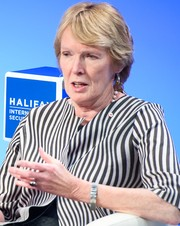

In [134]:
Image(requests.get('https://covers.openlibrary.org/a/id/9245942-M.jpg').content)

## bio

In [135]:
[(m.get('name'), m.get('bio')
 )
  for m in author_metadata.values() if m.get('bio')][:5]

[('Margaret Olwen Macmillan',
  {'type': '/type/text',
   'value': 'https://en.wikipedia.org/wiki/Margaret_MacMillan'}),
 ('Ernest Renan',
  {'type': '/type/text',
   'value': 'Joseph Ernest Renan (27 February 1823 – 2 October 1892) was a French Orientalist and Semitic scholar, expert of Semitic languages and civilizations, historian of religion, philologist, philosopher, biblical scholar and critic. He wrote influential and pioneering historical works on the origins of early Christianity, and espoused popular political theories especially concerning nationalism and national identity. Renan is credited as being among the first scholars to advance the Khazar theory, which helds that Ashkenazi Jews were descendants of the Khazars, Turkic peoples who had adopted Jewish religion and migrated to Western Europe following the collapse of their khanate.\r\n\r\n**Source**: [Ernest Renan](https://en.wikipedia.org/wiki/Ernest_Renan) on Wikipedia'}),
 ('Ombretta De Biase',
  {'type': '/type/text',